In [65]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio

In [66]:
def add_gaussian_noise(img, disp):
    zg = np.random.normal(0, disp, np.shape(img))
    imgzg = np.clip(img + zg, a_min=0, a_max=255)
    return imgzg

def add_impulsive_noise(img, p0, p1):
    L, C, pl = np.shape(img)
    Nrpix0 = int(L * C * p0)
    Nrpix1 = int(L * C * p1)

    imgzg = img.copy()
    for plan_curent in range(pl):
        numere_intregiL = np.random.randint(0, L, Nrpix0)
        numere_intregiC = np.random.randint(0, C, Nrpix0)
        imgzg[numere_intregiL, numere_intregiC, plan_curent] = 0

        numere_intregiL = np.random.randint(0, L, Nrpix1)
        numere_intregiC = np.random.randint(0, C, Nrpix1)
        imgzg[numere_intregiL, numere_intregiC, plan_curent] = 255
    return imgzg

In [67]:
def mse(img0, img):
    MSE = np.sum((img - img0) ** 2) / np.prod(np.shape(img))
    sumval = np.sum(img0 ** 2) / np.prod(np.shape(img))
    NMSE = MSE / sumval
    return MSE, NMSE

def psnr(img0, img):
    return peak_signal_noise_ratio(img0, img, data_range=255)

def ssim(img0, img):
    return structural_similarity(img0, img, channel_axis=-1, data_range=255)

(512, 512, 3)


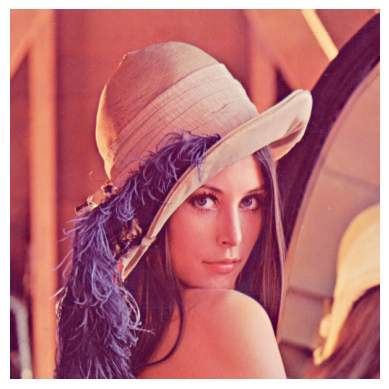

In [68]:
img = io.imread('lena.png')
plt.figure(), plt.imshow(img), plt.axis('off')
img = img[:, :, 0:3]
print(np.shape(img))

c:\Users\tiber\anaconda3\envs\paic\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


MSE GAUSSIAN: 99.19, NMSE GAUSSIAN: 0.9256
MSE IMPULSIVE: 10.17, NMSE IMPULSIVE: 0.0949
MSE ORIGINAL: 0.00, NMSE ORIGINAL: 0.0000
PSNR GAUSSIAN: 28.17
PSNR IMPULSIVE: 15.39
PSNR ORIGINAL: inf
SSIM GAUSSIAN: 0.64
SSIM IMPULSIVE: 0.19
SSIM ORIGINAL: 1.00


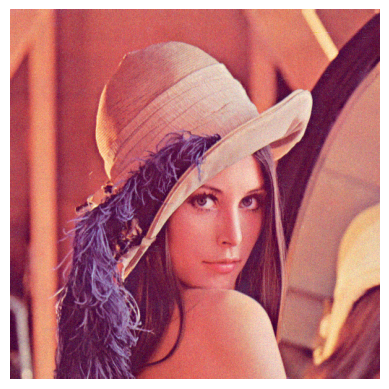

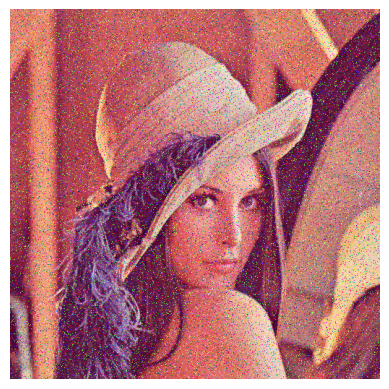

In [69]:
imgzg_gaussian = add_gaussian_noise(img, 10)
plt.figure(), plt.imshow(np.uint8(imgzg_gaussian)), plt.axis('off')

imgzg_impulsive = add_impulsive_noise(img, 0.05, 0.05)
plt.figure(), plt.imshow(np.uint8(imgzg_impulsive)), plt.axis('off')

PSNR_gaussian = psnr(img, imgzg_gaussian)
PSNR_impulsive = psnr(img, imgzg_impulsive)
PSNR_orig = psnr(img, img)

SSIM_gaussian = ssim(img, imgzg_gaussian)
SSIM_impulsive = ssim(img, imgzg_impulsive)
SSIM_orig = ssim(img, img)

print(f"PSNR GAUSSIAN: {PSNR_gaussian:.2f}")
print(f"PSNR IMPULSIVE: {PSNR_impulsive:.2f}")
print(f"PSNR ORIGINAL: {PSNR_orig:.2f}")
print(f"SSIM GAUSSIAN: {SSIM_gaussian:.2f}")
print(f"SSIM IMPULSIVE: {SSIM_impulsive:.2f}")
print(f"SSIM ORIGINAL: {SSIM_orig:.2f}")